In [1]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from tqdm.notebook import tqdm
import time
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import kwant
import math
from math import  sqrt
import cmath
from numpy.lib.scimath import sqrt as csqrt
import scipy
from scipy.optimize import fsolve
import copy
from itertools import repeat
from IPython.display import clear_output

In [2]:
# Defining the Jordan Wigner transformation for a 1D lattice
def jordan_wigner_transform(j, lattice_length):
    for k in range(j):
        if k == 0:
            operators = sigmaz()
        else:
            operators = tensor(operators, sigmaz())
    if j == 0:
        operators = sigmap()
    else:
        operators = tensor(operators, sigmap())
    for k in range(lattice_length - j - 1):
        operators = tensor(operators, identity(2))
    return operators

# Define rho0 distribution
def Lorentzian(omega, Gamma, poles):
    Rho0 = Gamma / np.pi / (omega ** 2 + Gamma ** 2)
    p = np.random.uniform(0, 1, poles)
    Rhoint = np.zeros(poles)
    for i in range(len(p)):
        Rhoint[i] = Gamma * math.tan(np.pi * (p[i] - 1 / 2))  ###p[i]-1/2
    return Rho0, Rhoint

# Calculates parameters impengergy,bathenergy and Vkk from random sampling distribution
def nonintG(omega, eta, select):
    G = 0
    for i in range(len(select)):
        G = G + 1 / len(select) / (omega - select[i] + 1.j * eta)
    return G

def HamiltonianAIM(c, impenergy, bathenergy, Vkk, U, Sigma,impn,crossn,bathn,Un,Sigman):
    H = 0
    H += impenergy * impn
    for j in range(len(bathenergy)):
        H += Vkk[j] * crossn[j]
        H += bathenergy[j] * bathn[j]
    error=False
    try:
        eigs=H.eigenstates()
        for i in range(len(eigs[1])):
            eigs[1][i]=eigs[1][i].full()
        exp= np.vdot(eigs[1][0], np.dot(n.full(), eigs[1][0]))
    except np.linalg.LinAlgError:
        error=True
        exp=0
        eigs=0
    except ValueError:
        error=True
        exp=0
        eigs=0
    H += U * Un
    H += -Sigma * Sigman
    return H,exp,error

def MBGAIM(omega, eigs, c, eta):
    MBG = np.zeros(len(omega),dtype = 'complex_')
    for i in range(1, len(eigs[0])):
        exp = np.vdot(eigs[1][i], np.dot(c[0].full(), eigs[1][0]))
        exp2 = np.vdot(eigs[1][i], np.dot(c[0].dag().full(), eigs[1][0]))
        k = abs(exp) ** 2
        l = abs(exp2) ** 2
        final = k / (omega + eigs[0][i] - eigs[0][0] + 1.j * eta) + l / (omega + eigs[0][0] - eigs[0][i] + 1.j * eta)
        MBG += final
    return MBG

# Gives Green’s function for the impurity level in the full interacting system (up and down spin)
def AIMsolver(impenergy, bathenergy, Vkk, U, Sigma, omega, eta, c,reset,impn,crossn,bathn,Un,Sigman,it):
    MBG = np.zeros(len(omega),dtype = 'complex_')
    H,exp2,error= HamiltonianAIM(c, impenergy, bathenergy, Vkk, U, Sigma,impn,crossn,bathn,Un,Sigman)
    print("--- %s s first part %d-%s--" % ((time.time() - start_time) ,attempts,it), end='\r')
    if not error:
        eigs=H.eigenstates()
        for i in range(len(eigs[1])):
            eigs[1][i]=eigs[1][i].full()
        
        exp= np.vdot(eigs[1][0], np.dot(n.full(), eigs[1][0]))
        if np.round(exp)==np.round(exp2):
            reset=True
            print("--- %s s second part %d-%s--" % ((time.time() - start_time) ,attempts,it), end='\r')
            MBG = MBGAIM(omega, eigs, c, eta)
            MBGAIM_jit=jit()(MBGAIM)
            %time MBGAIM_jit(omega, eigs, c, eta)
        return MBG,reset
    else:
        return MBG,reset

def Pcal(poles,pos):
    di=np.full((poles-1, poles), np.zeros(poles))
    for i in range(poles-1):
        for j in range(poles-1):
            if j>=i:
                di[i][j+1]=-1/sqrt((poles-i-1)*(poles-i))
        di[i][i]=sqrt(poles-i-1)/sqrt(poles-i)
    di=np.insert(di, pos,1/sqrt(poles),axis=0)
    return di

def DPgen(poles,select,pos):
    Pbath =np.array(Pcal(poles,pos))
    s = (poles,poles)
    Dbath=np.zeros(s)
    for i in range(len(select)):
        Dbath[i][i]=select[i]
    M=np.dot(Pbath,np.dot(Dbath,Pbath.T))
    return M

def startrans(poles,select,row,col):
    ham_mat=DPgen(poles,select,row)
    Hkk=np.delete(np.delete(ham_mat,row,axis=0),row,axis=1)
    eigkk,veckk=np.linalg.eig(Hkk)
    pbar=np.insert(np.insert(veckk, row,0,axis=0),row,0,axis=1)
    pbar[row][row]=1
    Hp=np.dot(pbar.T,np.dot(ham_mat,pbar))
    return Hp

def op(c,poles):
    impn=0
    crossn=[]
    bathn=[]
    for i in range(2):
        impn += (c[i].dag() * c[i])
    for j in range(poles-1):
        crossc=0
        bathc=0
        for i in range(2):
            crossc+=c[i].dag() * c[2 * j + i + 2] + c[2 * j + i + 2].dag() * c[i]
            bathc+=c[2 * j + i + 2].dag() * c[2 * j + i + 2]
        crossn.append(crossc)
        bathn.append(bathc)
    Un = (c[0].dag() * c[0] * c[1].dag() * c[1])
    Sigman = (c[0].dag() * c[0] + c[1].dag() * c[1])
    return impn,crossn,bathn,Un,Sigman

omega= np.logspace(-20.0, 1.0, num=3000, base = 3)
omega=np.concatenate((-np.flip(omega),omega))
print(omega,omega[3000],omega[2999])

[-3.         -2.97700999 -2.95419616 ...  2.95419616  2.97700999
  3.        ] 2.8679719907924413e-10 -2.8679719907924413e-10


In [4]:
from numba import jit
poles=4
Gamma=0.3
%time Lorentzian(omega, Gamma, poles)
Lorentzian_jit=jit()(Lorentzian)

CPU times: total: 0 ns
Wall time: 0 ns


In [5]:
%time Lorentzian_jit(omega, Gamma,poles)

CPU times: total: 578 ms
Wall time: 848 ms


(array([0.01050528, 0.01066652, 0.01083021, ..., 0.01083021, 0.01066652,
        0.01050528]),
 array([ 0.30988409,  0.55582863, -0.53831107, -0.35406734]))

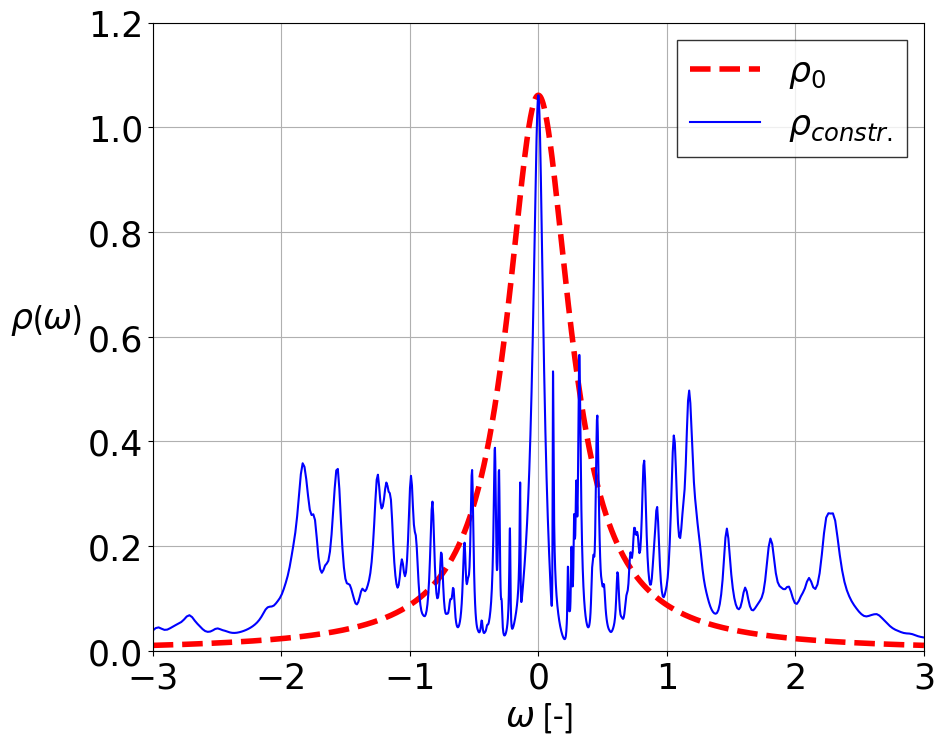

C:\Users\roelv\AppData\Local\Temp\ipykernel_25476\1153337613.py:56: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "MBGAIM" failed type inference due to: non-precise type pyobject
During: typing of argument at C:\Users\roelv\AppData\Local\Temp\ipykernel_25476\1153337613.py (57)

File "..\..\Users\roelv\AppData\Local\Temp\ipykernel_25476\1153337613.py", line 57:
<source missing, REPL/exec in use?>

  def MBGAIM(omega, eigs, c, eta):
C:\Users\roelv\AppData\Local\Temp\ipykernel_25476\1153337613.py:56: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "MBGAIM" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "..\..\Users\roelv\AppData\Local\Temp\ipykernel_25476\1153337613.py", line 58:
<source missing, REPL/exec in use?>

  def MBGAIM(omega, eigs, c, eta):
c:\Users\roelv\OneDrive\Documenten\VSC\.conda\lib\site-packages\numba\

In [6]:
#omega= np.linspace(-3,3,1001)
N=20000
poles=4
U=3
Sigma=U/2
Gamma=0.3
AvgSigmadat=np.zeros(len(omega),dtype = 'complex_')
lattice_length = 2+2*(poles-1)
c = []
for i in range(lattice_length):
    c.append(jordan_wigner_transform(i, lattice_length))
n=0
for i in range(lattice_length):
    n+=c[i].dag()*c[i]
Ntot=0
impn,crossn,bathn,Un,Sigman=op(c,poles)
for i in tqdm(range(N)):
    start_time = time.time()
    attempts=0
    reset=False
    while not reset:
        select=sorted(Lorentzian(omega, Gamma, poles)[1])
        NewM=startrans(poles,select,0,0)
        bathenergy=[]
        impenergy=NewM[0][0]
        for k in range(len(NewM)-1):
            bathenergy.append(NewM[k+1][k+1])
        Vkk=NewM[0,1:]
        eta=0.02*abs(omega)
        MBGdat,reset=AIMsolver(impenergy, bathenergy, Vkk, U,Sigma,omega,eta,c,reset,impn,crossn,bathn,Un,Sigman,i)
        NewSigmadat=1/nonintG(omega,eta,select)-1/MBGdat+Sigma
        if np.isnan(NewSigmadat).any() or any(i >= 1000 for i in np.real(NewSigmadat)):
            reset=False
        #else:
        #    Ntot+=1
        #    AvgSigmadat2=AvgSigmadat2+NewSigmadat
        attempts+=1
    AvgSigmadat=AvgSigmadat+NewSigmadat
    Ed=-(AvgSigmadat[3000]+AvgSigmadat[2999])/2
    finalG=np.nan_to_num(1/(omega-AvgSigmadat/(i+1)-Ed/(i+1)+1j*Gamma))
    #finalG2=np.nan_to_num(1/(omega-AvgSigmadat2/Ntot+AvgSigmadat2[500]/Ntot+1j*Gamma))
    fDOS=-np.imag(finalG)/np.pi
    clear_output(wait=True)
    font = {'size'   : 25}
    plt.rc('legend', fontsize=25)
    plt.rc('font', **font)
    plt.rc('xtick', labelsize=25)
    plt.rc('ytick', labelsize=25)
    axis_font = {'fontname':'Calibri', 'size':'25'}
    plt.figure(figsize=(10,8))
    plt.xlim(min(omega), max(omega))
    plt.gca().set_ylim(bottom=0,top=1.2)
    plt.xlabel("$\\omega$ [-]", **axis_font)
    plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=30,**axis_font)
    plt.plot(omega,Lorentzian(omega,Gamma,poles)[0], '--r',linewidth=4,label='$\\rho_0$')
    plt.plot(omega, fDOS,'-b',label='$\\rho_{constr.}$')
    plt.legend(fancybox=False).get_frame().set_edgecolor('black')
    plt.grid(b='on')
    plt.tight_layout()
    plt.show()

#for i in range(50):
#    clear_output(wait=True)
#    y = np.random.random([10,1])
#    plt.plot(y)
#    plt.show()